# Create MODFLOW6-grid-based tiff files and model_grid.csv file from GIS data sources

In [1]:
# This first cell imports needed modules and sets a few display options

%matplotlib notebook

import os
import datetime as dt
import pickle, joblib

# Standard data science libraries
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.optimize as so 
import scipy.interpolate as si

# Visualization
import matplotlib.pyplot as plt
# import seaborn as sns
plt.style.use('seaborn-notebook')

# Options for pandas
pd.options.display.max_columns = 20
pd.options.display.max_rows = 50

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import Image
from IPython.display import Math

import scipy.ndimage as nd
import scipy.spatial as sp
import geopandas as gpd
from shapely.geometry import Polygon
import gdal
gdal.UseExceptions()
import flopy as fp

import Genmod_Utilities as gmu
import json

In [2]:
with open('GenMod_metadata.txt') as json_file:
    metadata = json.load(json_file)

## Specify horizontal grid resolution

`number_of_grid_divisions`: *integer*, The general simulation model (**GSM**) grid is based on a specified integer number of cell divisions of the grid specified by Clark and others (2018) (**natgrid**). Here the user can specifiy splitting those cells into an integer number of equal subdivisions. **natgrid** has 1000 m pixels, so for example `number_of_grid_divisions` = 4 leads to 250 m pixels in **GSM**.  

Clark, B.R., Barlow, P.M., Peterson, S.M., Hughes, J.D., Reeves, H.W., and Viger, R.J., 2018, National-scale grid to support regional groundwater availability studies and a national hydrogeologic database: U.S. Geological Survey data release, https://doi.org/10.5066/F7P84B24.

In [3]:
# cell divisions
number_of_grid_divisions = 1
gsm_delxy= 1000 / number_of_grid_divisions

## Specify geospatial data sources

Specify how geospatial data will be mapped onto the model grid. Data sources are each specified in tuples in a list. There is a list for vector sources and a list for raster sources. The geospatial data in these sources will be rasterized, resampled, and reprojected onto the model grid. The rasterized values will be stored in GeoTiff files and as columns in the file `model_grid.csv`. 

Each vector source is specified by a tuple (which means that the values, separated by commas, are enclosed in parentheses) in a list. The elements of each tuple are
* pathname to source (usually a shapefile but other formats are supported)
* field name (or column or attribute or label) in the input data source that will be rasterized
* field name for the output data to used in `model_grid.csv`; the same name is given to the GeoTiff file for that data source

Raster sources are also specified in tuples, the elements of which are
* `natgrid_pth`: *string*, location of National Groundwater Grid tif file 


* pathname to source (many formats are supported)
* method, usually `gdal.GRA_Bilinear` or `gdal.GRA_NearestNeighbour`, although other methods are available.  See the documentation for Genmod_Utilities for other methods.
* conversion factor by which to multiply the source (e.g., factor=100 to convert cm in the input to m in the output)
* field name for the output data to used in `model_grid.csv`; the same name is given to the GeoTiff file for that data source


In [4]:
natgrid_pth = os.path.join('national_spatial_data', 'grid', 'natlGrid1km.tif')

# (src, attribute, name)

vector_list = [
#     (os.path.join('national_spatial_data', 'NHDPlusNationalData', 'gageloc.shp'), 
#      'REACHCODE', 'gage_id'),
    
#     (os.path.join('national_spatial_data', 'USGS_DS_425_SHAPES', 'Surficial_materials_K_added.shp'), 
#      'K', 'K_surf'),
    
#     (os.path.join('national_spatial_data', 'GLHYMPS', 'GLHYMPS_K_added.shp'), 
#      'K', 'K_glhymps'),
]


# (src, method, factor, name)

raster_list = [
    (os.path.join(metadata['raster_name'], 'elev_cm.tif'),
    gdal.GRA_Bilinear, 0.01, 'ned'),

    (os.path.join(metadata['raster_name'], 'cat.tif'),
    gdal.GRA_NearestNeighbour, 1, 'catchment'),

    (os.path.join('national_spatial_data', 'EffRecharge_0013_v2', 'EffRecharge_0013 (1)', '0013', 'RC_eff_0013.tif'),
    gdal.GRA_Bilinear, 1/365.25, 'recharge'),

    (os.path.join('national_spatial_data', 'b_r_Shan.tif'),
    gdal.GRA_Bilinear, 1., 'thickness_Shang'),

    (os.path.join('national_spatial_data', 'K_s_dry_mod_md.tif'),
    gdal.GRA_Bilinear, 1., 'surf_K'),
    
    (os.path.join('national_spatial_data', 'K_b_dry_mod_md.tif'),
    gdal.GRA_Bilinear, 1., 'bed_K'),    

    (os.path.join(metadata['ngwm_dir'], 'k_lay_0.tif'),
    gdal.GRA_Bilinear, 1, 'k_ngwm'),
    
    (os.path.join(metadata['ngwm_dir'], 'k33_lay_0.tif'),
    gdal.GRA_Bilinear, 1, 'k33_ngwm'),
    
    (os.path.join(metadata['ngwm_dir'], 'botm_lay_0.tif'),
    gdal.GRA_Bilinear, 1, 'botm_ngwm'),
    
    (os.path.join(metadata['ngwm_dir'], 'idomain_lay_0.tif'),
    gdal.GRA_Bilinear, 1, 'idomain_ngwm'),
    
    (os.path.join(metadata['ngwm_dir'], 'ss_lay_0.tif'),
    gdal.GRA_Bilinear, 1, 'ss_ngwm'),
    
    (os.path.join(metadata['ngwm_dir'], 'strt_lay_0.tif'),
    gdal.GRA_Bilinear, 1, 'strt_ngwm'),
    
    (os.path.join(metadata['ngwm_dir'], 'sy_lay_0.tif'),
    gdal.GRA_Bilinear, 1, 'k33_ngwm'),
    
    (os.path.join(metadata['ngwm_dir'], 'top.tif'),
    gdal.GRA_Bilinear, 1, 'top_ngwm')
]

Read the National Groundwater Grid

In [5]:
natgrid = gmu.SourceProcessing()
natgrid.read_raster(natgrid_pth)
proj = natgrid.output_raster_prj

Read the model domain shapefile

In [6]:
shp = gpd.read_file(metadata['domain_name'])
shp.to_crs(proj, inplace=True)

## Establish model grid -- derived from National Groundwater Model grid

Extract the part of the national grid (**natgrid**) that contains the model domain. Establish the dimensions and cell size of the general simulation model (**gsm**) grid based on the specified number of **natgrid** cell divisions.

In [7]:
# get coordinates of origin (x0, y0) and pixel (cell) size from natgrid
natgrid_x0, natgrid_pixelx, dum, natgrid_y0, dum, natgrid_pixely = natgrid.gt

# length of sides of natgrid
natgrid_lenx = natgrid_pixelx * natgrid.ncol
natgrid_leny = natgrid_pixely * natgrid.nrow

# number of gridlines in each direction in the gsm grid
natgrid_number_x_lines = natgrid.ncol * number_of_grid_divisions + 1
natgrid_number_y_lines = natgrid.nrow * number_of_grid_divisions + 1 

# make an array of natgrid line coorindates
natgrid_x_lines = np.linspace(natgrid_x0, natgrid_x0 + natgrid_lenx, natgrid_number_x_lines)
natgrid_y_lines = np.linspace(natgrid_y0, natgrid_y0 + natgrid_leny, natgrid_number_y_lines)

# min and max of bounding box around gsm domain
gsm_minx, gsm_miny, gsm_maxx, gsm_maxy = np.squeeze(shp.bounds.values)

# find the natgrid lines that bound the gsm domain
gsm_x0 = natgrid_x_lines[natgrid_x_lines <= gsm_minx][-1]
gsm_xm = natgrid_x_lines[natgrid_x_lines >= gsm_maxx][0]
gsm_ym = natgrid_y_lines[natgrid_y_lines <= gsm_miny][0]
gsm_y0 = natgrid_y_lines[natgrid_y_lines >= gsm_maxy][-1]

# length of sides of gsm grid
gsm_lenx = gsm_xm - gsm_x0
gsm_leny = gsm_ym - gsm_y0

# number of rows and columns for gsm
gsm_ncol = np.int32(np.abs(gsm_lenx / gsm_delxy))
gsm_nrow = np.int32(np.abs(gsm_leny / gsm_delxy)) 

# row and column spacinf for gsm
gsm_delr = gsm_delxy
gsm_delc = gsm_delxy

# blank raster in memory in the shape of the gsm grid
grid_raster = gmu.SourceProcessing(np.nan)
grid_raster.create_raster(0, (gsm_x0, gsm_y0), gsm_delr, gsm_delc, gsm_nrow, gsm_ncol, proj)


Establish bounding box for grid. Save the bounding box to a shapefile.

In [8]:
coords = ((gsm_x0, gsm_y0), (gsm_xm, gsm_y0), (gsm_xm, gsm_ym), (gsm_x0, gsm_ym))
polygon = gpd.GeoSeries(Polygon(coords))
box = gpd.GeoDataFrame(geometry=polygon, crs=proj)
box.crs = proj

box.to_file(os.path.join(metadata['gis_dir'], 'clip_box.shp'))

Establish a FloPy grid object

In [9]:
delc_ar = np.ones((gsm_nrow)) * gsm_delc
delr_ar = np.ones((gsm_ncol)) * gsm_delr

ml = fp.discretization.structuredgrid.StructuredGrid(
    delc=delc_ar, delr=delr_ar, xoff=gsm_x0, yoff=gsm_y0+gsm_leny, angrot=0, lenuni=2)

## Create drainage network

Read and intersect flowline file with domain outline. These are from the high resolution NHDPlus flow lines and the associated value-added attribute table (VAA). Flow lines are merged with the VAA and the resulting file is cleaned up. The merged file is converted back to a GeoDataFrame and saved as a shapefile.

In [10]:
# read high resolution NHDPlus flow lines
flowlines = gpd.read_file(metadata['vector_name'], layer='NHDFlowline')
flowlines.to_crs(crs=proj, inplace=True)

# clip flow lines to the model domain and select columns
nhd_clip = gpd.overlay(flowlines, shp)
nhd_clip = nhd_clip[['Permanent_Identifier', 'NHDPlusID', 'ReachCode', 'ibound', 'geometry']]

# check that the clipped file is not empty
assert nhd_clip.shape[0] != 0, 'The model domain is not in the area covered by the downloaded NHDPlus'

# read the VAA and select columns
VAA_tab = gpd.read_file(metadata['vector_name'], layer='NHDPlusFlowlineVAA')
VAA_tab = VAA_tab[['NHDPlusID', 'StreamOrde', 'MaxElevSmo', 'MinElevSmo']]

# merge selected fields from the associated tables into the clipped flow lines
# this step takes the data frame from geopandas to pandas and loses the geographic information
nhd_clip = nhd_clip.merge(VAA_tab, how='inner', on='NHDPlusID')

# convert elevation in cm to meters
nhd_clip['maxft'] = nhd_clip.MaxElevSmo / 100.
nhd_clip['minft'] = nhd_clip.MinElevSmo / 100.

# convert the merged file back to a GeoDataFrame (geopandas) and it save as a shapefile
nhd_clip = gpd.GeoDataFrame(nhd_clip, geometry=nhd_clip.geometry, crs=proj)
nhd_clip.to_file(os.path.join(metadata['gis_dir'], 'NHD_clip.shp'))

C:\Users\jjstarn\Miniconda3\envs\genmod20\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


Calculate drain stage at cell centers and extract ancillary data. This step used FloPy's internal intersection function. 

In [11]:
# Create a FloPy GridIntersect object
ix = fp.utils.gridintersect.GridIntersect(ml)

# start a blank dataframe for drain data
drains = pd.DataFrame()

# loop through each stream reach and intersect with the model grid
for index, reach in nhd_clip.iterrows():
    reach_len = reach.geometry.length
    # the procedure is different if the reach is a single line or multiple lines.
    # multiple lines can occur if a reach enters and exits a cell more than once
    if  reach.geometry.geom_type is 'MultiLineString':
        for multi_reach in reach.geometry:
            result = ix.intersect(multi_reach)
    else:
        result = ix.intersect(reach.geometry)
    
    # put the results of the intersection in a temporary dataframe
    df = pd.DataFrame(result)
    
    # calculate the stage as the mean of the upstream and downstream elevations
    cumlen = np.cumsum(df.lengths)
    midpoint = cumlen - df.lengths / 2
    rise = reach.maxft - reach.minft
    grad = rise / reach_len
    stage = midpoint * grad
    
    # add some new fields and append the temporary dataframe to the drain data
    df['stage'] = reach.maxft - stage
    df['reach'] = index
    df['order'] = reach.StreamOrde
    df['NHDPlusID'] = reach.NHDPlusID
    df['reachcode'] = reach.ReachCode
    drains = drains.append(df)

In [12]:
# reset the index
drains.reset_index(inplace=True)

# parse row and col into separate columns
drains[['row', 'col']] = pd.DataFrame(drains['cellids'].tolist(), index=drains.index) 

# convert NHDPlusID to a long integer
drains['NHDPlusID'] = drains.NHDPlusID.astype(np.int64)

# add a node number based on the left-to-right top-to-bottom sequence number
drains['node'] = drains.row * gsm_ncol + drains.col

# create a GeoDataFrame of the drain data
gdf = gpd.GeoDataFrame(drains, geometry='ixshapes', crs=proj)

# drop unused columns
gdf.drop(columns=['cellids', 'vertices'], inplace=True)

# save to a shapefile
gdf.to_file(os.path.join(metadata['gis_dir'], 'drain_segments.shp'))

## Create lakes

Read and intersect waterbody file with domain outline. TODO: Need to look at possible duplication of lake cells and weeding some lakes out by size; maybe as a fraction of the cell size.



In [13]:
# read high resolution NHDPlus waterbodies
lakes = gpd.read_file(metadata['vector_name'], layer='NHDWaterbody')
lakes.to_crs(crs = proj, inplace=True)

# clip waterbodies to the model domain and create an indicator column
lake_clip = gpd.overlay(lakes, shp)
lake_clip['is_lake'] = 1

# save as a shapefile
lake_clip.to_file(os.path.join(metadata['gis_dir'], 'lake_clip.shp'))

C:\Users\jjstarn\Miniconda3\envs\genmod20\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  # Remove the CWD from sys.path while we load stuff.


In [14]:
# start a blank dataframe for lake data
lakes = pd.DataFrame()

# loop through each waterbody and intersect with the model grid
for index, segment in lake_clip.iterrows():
    result = ix.intersect(segment.geometry)
    # put the results of the intersection in a temporary dataframe
    df = pd.DataFrame(result)
    # add some new fields and append the temporary dataframe to the drain data
    df['segment'] = index
    lakes = lakes.append(df)

# reset the index
lakes.reset_index(inplace=True)

# parse row and col into separate columns
lakes[['row', 'col']] = pd.DataFrame(lakes['cellids'].tolist(), index=lakes.index) 

# add a node number based on the left-to-right top-to-bottom sequence number
lakes['node'] = lakes.row * gsm_ncol + lakes.col 

# create a GeoDataFrame of the drain data
lakes = gpd.GeoDataFrame(lakes, geometry='ixshapes', crs=proj)

# drop unused columns
lakes.drop(columns=['cellids', 'vertices'], inplace=True)    

# save to a shapefile
lakes.to_file(os.path.join(metadata['gis_dir'], 'lake_segments.shp'))

## Map drain and lake properties onto the model grid

In [15]:
# create a blank dataframe with a row for every model cell in map view (nrow * ncol)
model_grid = pd.DataFrame({'node': np.arange(gsm_nrow * gsm_ncol)})

# group the drain segments by model cell using node
for i, j in drains.groupby('node'):
    # if there is more than one segment in a cell, use the most downstream cell (minimum stage)
    # multiple segments can occur if a reach enters and exits a cell more than once
    index = j.stage.idxmin()
    model_grid.loc[i, 'stage'] = j.loc[index, 'stage']
    model_grid.loc[i, 'order'] = j.loc[index, 'order']
    model_grid.loc[i, 'NHDPlusID'] = j.loc[index, 'NHDPlusID']
    model_grid.loc[i, 'reach_len'] = j.lengths.sum()
    
# group the lake segments by model cell using node
# calculate the total area of all waterbodies in each cell 
for i, j in lakes.groupby('node'):
    model_grid.loc[i, 'lake_areas'] = j.areas.sum()

## Map other spatial data onto model grid

Add ibound to model grid data frame. Cells whose centers are in the watershed polygon will be active.

In [16]:
grid_raster.process_vector_data(metadata['domain_name'], 'ibound')
ib = grid_raster.new_array

Filter ibound to eliminate disconnected cells

In [17]:
# Removes isolated active cells from the IBOUND array.
# Args: ibound array (nlay, nrow, ncol)
# this cell is from Wesley Zell

# Distinguish disconnected clusters of active cells in the IBOUND array.
# 0 is considered background; in MODLFOW, active cells are != 0.
ib[ib != 0] = 1
array_of_cluster_idx, num = nd.measurements.label(ib)

# Identify the cluster with the most active cells; this is the main active area
areas = nd.measurements.sum(ib, array_of_cluster_idx,\
                         index=np.arange(array_of_cluster_idx.max() + 1))
max_cluster_idx = np.argmax(areas)

# Inactivate all cells that belong to secondary clusters (e.g., islands)
ib[array_of_cluster_idx != max_cluster_idx] = 0
ib = ib.astype(int)
model_grid['ibound'] = ib.ravel()

Get rid of any data for cells where idomain != 1.  Removes the rows and then add back blank rows so that every top layer cell has a row.

In [18]:
model_grid = model_grid.loc[model_grid.ibound==1, :].reindex(np.arange(gsm_nrow * gsm_ncol))

Add vector data to model grid data frame. Any attributes can be added to the modelgrid DataFrame, including alternative data sources.  The connection between modelgrid and the MODFLOW model is made in the next notebook. 

In [19]:
for src, attribute, name in vector_list:
    grid_raster.process_vector_data(src, attribute)
    model_grid[name] = grid_raster.new_array.ravel()

Add raster data to model grid data frame. Any attributes can be added to the modelgrid DataFrame, including alternative data sources.  The connection between modelgrid and the MODFLOW model is made in the next notebook. 

In [20]:
for src, method, factor, name in raster_list:
    grid_raster.process_raster_data(src, method, factor)
    model_grid[name] = grid_raster.new_array.ravel() 

Data not processed for
downloads\0104_0106_0107_0109_MF6_SS_Unconfined_250\ss_lay_0.tif
 Check that the file exists and path is correct
Data not processed for
downloads\0104_0106_0107_0109_MF6_SS_Unconfined_250\sy_lay_0.tif
 Check that the file exists and path is correct


In [21]:
try:
    r_dir = '../gis/recharge'
    r_list = os.listdir(r_dir)
    
    for src in r_list:
        src_pth = os.path.join(r_dir, src)
        name = '_'.join(src.split('_')[0:2])
        if os.path.splitext(src_pth)[-1] == '.tif':
            grid_raster.process_raster_data(src_pth, gdal.GRA_Bilinear, 1.0)
            model_grid[name] = grid_raster.new_array.ravel()
except:
    print ('no transient recharge')

no transient recharge


The NHDPlus has a small number of MAXELEVSMO and MINELEVSMO in (mostly?) first order streams that are set to a missing value code -9980. Converted to meters this is -99.80. Replace all such values with the NED value minus 1 (meter). 

In [22]:
model_grid['stage'] = np.where(model_grid.stage == -99.80, model_grid.ned - 1., model_grid.stage)

Filter ibound to make a grid of edge cells. Intersect this with the lake grid. Cell that are on the edge of the model and are in lakes could be treated as GHB cells.  This is very similar to the code above for drain/river cells. FloPy GHB requires a dictionary of lists similar to river/drain.

In [23]:
# In case there is more than one polygon in the domain file (but there shouldn't be), 
# find the one with the largest area. Extract the boundary LineString of the polygon.
poly = max(shp.geometry, default=shp.geometry[0], key=lambda a: a.area).boundary

edge_nodes = []

# loop through rows and columns, find the cell center, intersect it with
# the polygon gon boundary.  If the intersection is True, append it to a list,
# otherwise append False)
for i in range(ml.nrow):
    for j in range(ml.ncol):
        xy = ml.get_cell_vertices(i, j)
        p = Polygon(xy)
        edge_nodes.append(p.intersects(poly))

model_grid['edge'] = edge_nodes

ghb = (model_grid.edge & model_grid.lake_areas.notnull())
ghb = ghb.astype(int)
model_grid['ghb'] = ghb.ravel()

GHB is used for marine boundaries along cells where the elevation or river stage is < sea level. Added by Janet Barclay.

In [24]:
sea_level = 0
den_salt = 1.2
den_fresh = 1.0
river_depth = 10.

In [25]:
model_grid['ghb_sea'] = 0
# setting the ghb for land surface below sea level
model_grid.loc[model_grid['ned'] <= sea_level, 'ghb_sea'] = 1

# convert the depth of saltwater to a freshwater head using the depth and the densities of each
# fresh_head = (den_sea / den_fresh)*sea_level - [(den_sea - den_fresh)/den_fresh]*depth_sea
model_grid['fresh_head'] = (den_salt / den_fresh) * sea_level - \
    ((den_salt - den_fresh) / den_fresh) * (sea_level - model_grid['ned'])

# changing rivers with stage < sea level to ghb
model_grid.loc[(model_grid['stage'] < sea_level) &
               (model_grid.stage > -9990), 'ghb_sea'] = 1
model_grid.loc[(model_grid['stage'] < sea_level) & (model_grid.stage > -9990), 'fresh_head'] = (den_salt / den_fresh) * sea_level - \
    ((den_salt - den_fresh) / den_fresh) * (sea_level -
                                      (model_grid.loc[(model_grid['stage'] < sea_level) & (model_grid.stage > -9990), 'stage'] - river_depth))

# change the stage to np.nan to avoid adding a drain as well
model_grid.loc[(model_grid['stage'] < sea_level) & (
    model_grid.stage > -9990), 'stage'] = np.nan

Replace grid-cell-mean NED elevations with interpolated stream stage, but only in model cells that contain a stream. The resulting data is called 'top'.

In [26]:
model_grid['top'] = model_grid.ned
index = model_grid.stage.notnull()
model_grid.loc[index, 'top'] = model_grid.stage

Replace grid-cell mean NED elevations with fresh head for ghb cells with top above fresh head

In [27]:
index = (model_grid.ghb_sea == 1) & (model_grid.fresh_head < model_grid.top)
model_grid.loc[index, 'top'] = model_grid.fresh_head

Add observation type to cells.  "hydro" if a perennial stream, "topo" everywhere else.

In [28]:
is_active = model_grid.ibound != 0
# is_intermit = model_grid.intermit == True
is_sea = model_grid.ghb_sea == 1
# marine cells (those with ghb_sea boundary) are included as hydro observations
hydro_index = model_grid.stage.notnull() | is_sea

is_hydro_obs = is_active & hydro_index# & ~is_intermit
is_topo_obs = is_active & ~is_hydro_obs & ~is_sea

model_grid['obs_type'] = np.nan
model_grid.loc[is_hydro_obs, 'obs_type'] = 1
model_grid.loc[is_topo_obs, 'obs_type'] = 2

Loop through all the columns in model_grid and write a GeoTiff of the data.

In [29]:
for column, item in model_grid.iteritems():
    fname = '{}.tif'.format(column)
#     dst = os.path.join(model_ws, fname)
#     if os.path.exists(dst):
#         os.remove(dst)
    data = item.values.reshape(gsm_nrow, gsm_ncol)
    grid_raster.new_array = data
    dst = os.path.join(metadata['gis_dir'], '{}.tif'.format(column))
    grid_raster.write_raster(dst, which_raster='new')

Add some additional columns to `model_grid` and write it to model_grid.csv

In [30]:
model_grid.loc[is_hydro_obs, 'obs_type'] = 'hydro'
model_grid.loc[is_topo_obs, 'obs_type'] = 'topo'

In [31]:
lays, rows, cols = np.indices((1, gsm_nrow, gsm_ncol))

model_grid['lay'] = lays.ravel()
model_grid['row'] = rows.ravel()
model_grid['col'] = cols.ravel()

Map stream order to a stream width using data from Downing et al, 2012. Order is the Strahler order and width is the trapezoidal width in meters.

J.A. Downing, J.J. Cole, C.M. Duarte, J.J. Middelburg, J.M. Melack, Y.T.
Prairie, P. Kortelainen, R.G. Striegl, W.H. McDowell & L.J. Tranvik (2012) Global abundance and
size distribution of streams and rivers, Inland Waters, 2:4, 229-236, DOI: 10.5268/IW-2.4.502

In [32]:
width_table = np.array([(1, 0.8),
(2, 1.8),
(3, 3.7),
(4, 8.3),
(5, 29.3),
(6, 73.3),
(7, 131.5),
(8, 264.5),
(9, 608.5),
(10, 988.5),
(11, 803.0),
(12, 3079.0)], dtype=[('order', '<i8'), ('width', '<f8')])

In [33]:
# map stream order to stream width based on Downing (2012)
model_grid['width'] = model_grid['order'].replace(
    width_table['width'])

In [34]:
x_gridlines = np.linspace(gsm_x0, gsm_xm, gsm_ncol + 1)
y_gridlines = np.linspace(gsm_y0, gsm_ym, gsm_nrow + 1)

model_grid['xvert_l'] = np.tile(x_gridlines[:-1], gsm_nrow)
model_grid['xvert_r'] = np.tile(x_gridlines[1:], gsm_nrow)
model_grid['yvert_t'] = np.repeat(y_gridlines[:-1], gsm_ncol)
model_grid['yvert_b'] = np.repeat(y_gridlines[1:], gsm_ncol)

In [35]:
model_grid.to_csv(os.path.join(metadata['gis_dir'], 'model_grid.csv'))

Plot domain outline, model grid, and drainage network

<IPython.core.display.Javascript object>


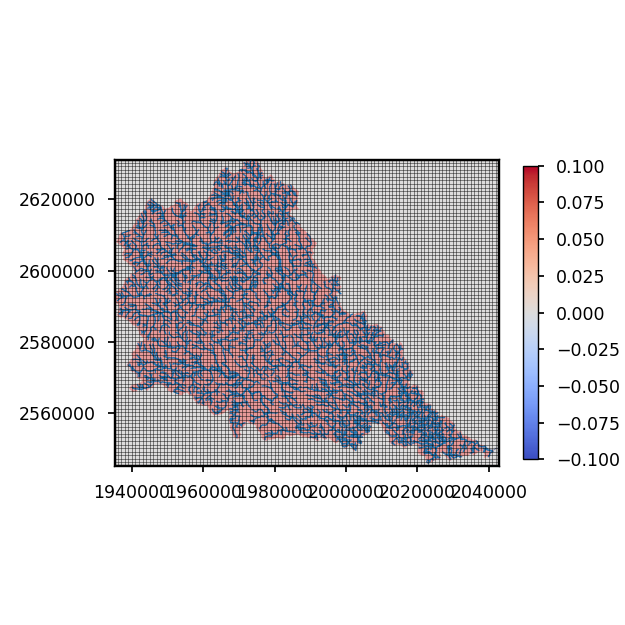

In [37]:
fig, ax = grid_raster.plot_raster()

dum = nhd_clip.plot(ax=ax, linewidth=0.75)
dum = shp.plot(ax=ax, color='red', alpha=0.3)
dum = box.plot(ax=ax, color='none', edgecolor='k', linewidth=2)
dum = ax.vlines(x_gridlines, gsm_y0, gsm_ym, linewidth=0.5, alpha=0.5)
dum = ax.hlines(y_gridlines, gsm_x0, gsm_xm, linewidth=0.5, alpha=0.5)

fig.set_tight_layout(True)